In [45]:
import numpy as np
import pandas as pd
from scipy import stats
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [46]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'AVGO', 'NVDA', 'SNOW']  
data = yf.download(tickers, start='2021-05-15', end='2024-09-17')['Adj Close']

[*********************100%%**********************]  10 of 10 completed


In [47]:
returns = data.pct_change().dropna()

In [48]:
cov_matrix = returns.cov()
expected_returns = returns.mean()

In [49]:
cov_matrix.head()

Ticker,AAPL,AMZN,AVGO,GOOGL,META,MSFT,NFLX,NVDA,SNOW,TSLA
Ticker,,,,,,,,,,
AAPL,0.000284,0.000222,0.000210,0.000209,0.000245,0.000194,0.000216,0.000321,0.000288,0.000311
AMZN,0.000222,0.000537,0.000264,0.000295,0.000402,0.000261,0.000338,0.000447,0.000521,0.000365
AVGO,0.000210,0.000264,0.000538,0.000218,0.000293,0.000218,0.000260,0.000550,0.000333,0.000372
GOOGL,0.000209,0.000295,0.000218,0.000387,0.000348,0.000237,0.000243,0.000379,0.000345,0.000277
META,0.000245,0.000402,0.000293,0.000348,0.000880,0.000291,0.000416,0.000502,0.000491,0.000344


In [50]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

In [51]:
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance_value = portfolio_variance(weights, cov_matrix)
    portfolio_std = np.sqrt(portfolio_variance_value)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

In [52]:
init_guess = np.array([1/len(tickers)] * len(tickers))
result = minimize(negative_sharpe_ratio, init_guess, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = result.x

In [53]:
opt_weights

array([1.05888199e-16, 0.00000000e+00, 4.95523870e-01, 0.00000000e+00,
       0.00000000e+00, 7.45092897e-18, 0.00000000e+00, 5.04476130e-01,
       4.66925124e-17, 0.00000000e+00])

[*********************100%%**********************]  1 of 1 completed


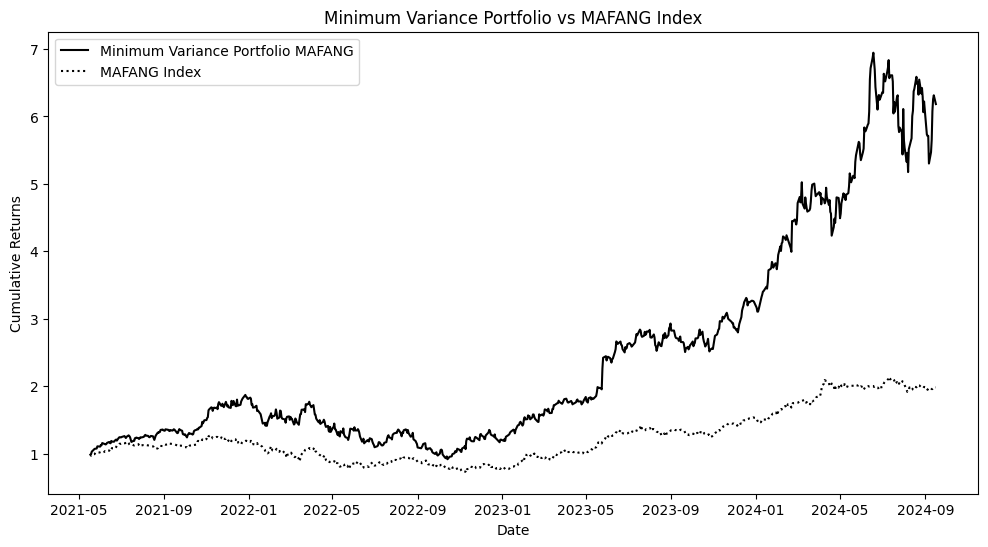

In [54]:
portfolio_returns = (returns * opt_weights).sum(axis=1)

market_data = yf.download('MAFANG.NS', start='2021-05-15', end='2024-09-17')['Adj Close']
market_returns = market_data.pct_change().dropna()
portfolio_cumulative = (1 + portfolio_returns).cumprod()
market_cumulative = (1 + market_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative, color='black', label='Minimum Variance Portfolio MAFANG')
plt.plot(market_cumulative, linestyle='dotted', color='black', label='MAFANG Index')
plt.title('Minimum Variance Portfolio vs MAFANG Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.savefig('MVP.png')
plt.show()

In [55]:
def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

risk_free_rate = 0.01 / 252

sharpe_mvp = sharpe_ratio(portfolio_returns, risk_free_rate)
sharpe_mafang = sharpe_ratio(market_returns, risk_free_rate)

print(f"Sharpe Ratio - MVP: {sharpe_mvp}, MAFANG Index: {sharpe_mafang}")

Sharpe Ratio - MVP: 0.09345740747598605, MAFANG Index: 0.05775611536174947


In [56]:
def max_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    return drawdown.min()

max_drawdown_mvp = max_drawdown(portfolio_cumulative)
max_drawdown_mafang = max_drawdown(market_cumulative)

print(f"Max Drawdown - MVP: {max_drawdown_mvp}, MAFANG Index: {max_drawdown_mafang}")

Max Drawdown - MVP: -0.5089566715977656, MAFANG Index: -0.4374691799409981


In [57]:
def sortino_ratio(returns, risk_free_rate=0):
    downside_risk = np.std(returns[returns < 0])  # only downside deviations
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / downside_risk

sortino_mvp = sortino_ratio(portfolio_returns, risk_free_rate)
sortino_mafang = sortino_ratio(market_returns, risk_free_rate)

print(f"Sortino Ratio - MVP: {sortino_mvp}, MAFANG Index: {sortino_mafang}")

Sortino Ratio - MVP: 0.15504035695823146, MAFANG Index: 0.08375525068721226


In [58]:
t_stat, p_value = stats.ttest_ind(portfolio_returns, market_returns)

print(f"t-Test: t-statistic = {t_stat}, p-value = {p_value}")

t-Test: t-statistic = 1.4565899379866467, p-value = 0.1454186076530709
